# Coal Inventory Scraper for Chinese Ports

This notebook contains a Python script that scrapes coal inventory data from the sxcoal.com website. It specifically targets articles containing "煤炭库存" (coal inventory) to extract date, port name, and inventory figures. The extracted data is then reshaped into a table and saved as a CSV file.

In [2]:
## need to install undetected_chromedriver and pandas if not already installed
# This script scrapes coal inventory data from a specific website, reshapes it, and exports
# the final table to a CSV file. It uses Selenium for web scraping and Pandas for data manipulation.
# File: coal_inventory_scraper.py
import pandas as pd
import re
from datetime import datetime
import time

try:
    import undetected_chromedriver as uc
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from selenium.common.exceptions import TimeoutException
except ImportError:
    print("Required libraries not found. Installing them now...")
    %pip install undetected-chromedriver pandas
    import undetected_chromedriver as uc
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from selenium.common.exceptions import TimeoutException

def scrape_export_inventory_data():
    """
    Final version: Scrapes all inventory articles, reshapes the data,
    and exports the final table to a CSV file.
    """
    search_url = "https://www.sxcoal.com/news/search?search=%E7%85%A4%E7%82%AD%E5%BA%93%E5%AD%98"
    csv_filename = "coal_inventory_data.csv"
    raw_data_list = []

    print("--- Initializing browser for scrape-and-export task ---")
    
    driver = None
    try:
        options = uc.ChromeOptions()
        options.add_argument('--headless')
        
        driver = uc.Chrome(options=options, use_subprocess=False)
        wait = WebDriverWait(driver, 25) 

        # Step 1: Gather URLs
        print(f"Navigating to: {search_url}")
        driver.get(search_url)

        print("\nFinding all relevant inventory articles...")
        article_link_selector = (By.PARTIAL_LINK_TEXT, "煤炭库存")
        
        try:
            wait.until(EC.element_to_be_clickable(article_link_selector))
            article_elements = driver.find_elements(*article_link_selector)
            article_urls = sorted(list(set([el.get_attribute('href') for el in article_elements])))
            print(f">>> Success! Found {len(article_urls)} unique articles to process.")
        except TimeoutException:
            print("\n--- FAILURE ---")
            print("Could not find any article links containing '煤炭库存'.")
            return None 

        # Step 2: Loop through URLs and extract data
        for i, url in enumerate(article_urls):
            print(f"\n--- Processing article {i+1} of {len(article_urls)} ---")
            try:
                driver.get(url)
                time.sleep(3) 
                page_text = driver.find_element(By.TAG_NAME, 'body').text
                pattern = re.compile(r"(\d+月\d+日)，([\u4e00-\u9fa5]+港)煤炭库存为(\d+\.?\d*)")
                match = pattern.search(page_text)
                
                if match:
                    date_str, port_name, inventory = match.groups()
                    raw_data_list.append({"Date": date_str, "Port": port_name.strip(), "Inventory": float(inventory)})
                    print(f"  >>> SUCCESS: Found [{date_str}] '{port_name.strip()}' with inventory {inventory}")
                else:
                    print(f"  > INFO: No data matching the required pattern was found.")
                    
            except Exception as e:
                print(f"  > ERROR: An error occurred processing this article: {type(e).__name__}")
        
        if not raw_data_list:
            print("\nScraping finished, but no data could be extracted.")
            return None
            
        # Step 3: Reshape the data
        print("\n--- Data extraction complete. Reshaping table... ---")
        long_df = pd.DataFrame(raw_data_list)
        current_year = datetime.now().year
        long_df['FullDate'] = long_df['Date'].apply(lambda x: datetime.strptime(f'{current_year}年{x}', '%Y年%m月%d日'))

        final_table = long_df.pivot_table(index='FullDate', columns='Port', values='Inventory')
        final_table.sort_index(ascending=False, inplace=True)
        final_table.reset_index(inplace=True)
        final_table.rename(columns={'FullDate': 'Date'}, inplace=True)
        final_table['Date'] = final_table['Date'].dt.strftime('%m-%d-%y')
        
        # ***4: EXPORT TO CSV ***
        print(f"\n--- Reshaping complete. Exporting data to '{csv_filename}'... ---")
        try:
            # We use index=False to avoid writing the pandas row numbers (0, 1, 2...) into the file.
            # encoding='utf-8-sig' helps Excel open the file correctly with Chinese characters.
            final_table.to_csv(csv_filename, index=False, encoding='utf-8-sig')
            print(f">>> SUCCESS: Data has been saved to {csv_filename}")
        except Exception as e:
            print(f"--- FAILED TO SAVE FILE: An error occurred: {e} ---")

        return final_table

    except Exception as e:
        print(f"\nA critical error occurred: {type(e).__name__} - {e}")
        return None
    finally:
        if driver:
            print("\nScript finished. Closing browser...")
            driver.quit()

# --- Run the scraper ---
final_inventory_data = scrape_export_inventory_data()

# --- Display the final DataFrame in the notebook for confirmation ---
if final_inventory_data is not None and not final_inventory_data.empty:
    print("\n\n--- FINAL DATA PREVIEW ---")
    display(final_inventory_data) 
else:
    print("\n\n--- TASK FAILED OR NO DATA FOUND ---")

--- Initializing browser for scrape-and-export task ---
Navigating to: https://www.sxcoal.com/news/search?search=%E7%85%A4%E7%82%AD%E5%BA%93%E5%AD%98
Navigating to: https://www.sxcoal.com/news/search?search=%E7%85%A4%E7%82%AD%E5%BA%93%E5%AD%98

Finding all relevant inventory articles...
>>> Success! Found 16 unique articles to process.

--- Processing article 1 of 16 ---

Finding all relevant inventory articles...
>>> Success! Found 16 unique articles to process.

--- Processing article 1 of 16 ---
  >>> SUCCESS: Found [7月2日] '秦皇岛港' with inventory 580

--- Processing article 2 of 16 ---
  >>> SUCCESS: Found [7月2日] '秦皇岛港' with inventory 580

--- Processing article 2 of 16 ---
  >>> SUCCESS: Found [7月2日] '黄骅港' with inventory 175.6

--- Processing article 3 of 16 ---
  >>> SUCCESS: Found [7月2日] '黄骅港' with inventory 175.6

--- Processing article 3 of 16 ---
  >>> SUCCESS: Found [7月3日] '秦皇岛港' with inventory 580

--- Processing article 4 of 16 ---
  >>> SUCCESS: Found [7月3日] '秦皇岛港' with inve

Port,Date,京唐港,曹妃甸港,秦皇岛港,黄骅港
0,07-09-25,701.0,1254.0,573.0,189.3
1,07-08-25,NaN,NaN,575.0,182.5
2,07-07-25,NaN,NaN,576.0,NaN
3,07-04-25,NaN,NaN,570.0,NaN
4,07-03-25,NaN,NaN,580.0,180.3
5,07-02-25,NaN,NaN,580.0,175.6


Here is a breakdown of the entire code, explaining its purpose and functionality step-by-step.
High-Level Goal
The script's main objective is to automate the following process:
Go to a Chinese coal industry website.
Find all news articles related to "coal inventory."
Visit each of those articles and extract specific data points: the date, the port name, and the inventory level.
Organize this scattered data into a clean, structured table.
Export this final table into a CSV file that can be easily opened in Excel or other data analysis tools.
Detailed Code Explanation
1. Imports and Setup
The script begins by importing necessary libraries. It includes a clever try...except block to ensure the required libraries are installed before use.
pandas as pd: A powerful library for data manipulation and analysis. It's used here to create and reshape the data into a final table (a DataFrame).
re: Python's built-in regular expression library, used for finding and extracting text that matches a specific pattern.
datetime: Used to handle and format dates correctly.
time: Used to pause the script execution (time.sleep()).
undetected_chromedriver as uc: A special version of the Selenium browser driver designed to be less detectable by websites that try to block automated scripts (bots).
selenium: The core library for browser automation. It allows the script to programmatically control a Chrome browser to navigate pages, find elements, and extract content.
2. The scrape_export_inventory_data() Function
This is the main function that contains all the logic.
search_url: The starting point for the scraper—a pre-defined search results page for "煤炭库存" (coal inventory).
csv_filename: The name of the file where the final data will be saved.
Browser Initialization:
It sets up Chrome to run in --headless mode, meaning no visible browser window will pop up. The entire process runs in the background.
driver = uc.Chrome(...) launches the automated browser.
wait = WebDriverWait(driver, 25) is an important tool for reliability. It tells Selenium to wait up to 25 seconds for certain conditions to be met before throwing an error, which prevents the script from failing on slow-loading pages.
driver.get(search_url): The browser navigates to the search results page.
driver.find_elements(By.PARTIAL_LINK_TEXT, "煤炭库存"): The script searches for all hyperlink elements (<a> tags) on the page whose visible text contains "煤炭库存". This is how it identifies the relevant articles.
article_urls = sorted(list(set([...]))): This line cleverly processes the found links.
It gets the href (the URL) from each link element.
It uses set() to automatically remove any duplicate URLs.
It converts the set back to a list and sorts it for consistent processing order.
The script now iterates through each unique URL it found.
driver.get(url): It visits each article page one by one.
time.sleep(3): It pauses for 3 seconds to allow dynamic content on the page to finish loading.
page_text = driver.find_element(By.TAG_NAME, 'body').text: It grabs all the visible text from the page.
Pattern Matching (Regular Expression):
pattern = re.compile(r"(\d+月\d+日)，([\u4e00-\u9fa5]+港)煤炭库存为(\d+\.?\d*)"): This is the core of the data extraction. It looks for a very specific text pattern:
(\d+月\d+日): A date like "8月23日".
([\u4e00-\u9fa5]+港): A port name, consisting of Chinese characters ending with "港" (port).
煤炭库存为: The literal text "coal inventory is".
(\d+\.?\d*): A number, which can be an integer or a decimal.
match = pattern.search(page_text): It searches the page text for this pattern.
If a match is found, it extracts the captured groups (date, port, inventory), stores them in a dictionary, and adds it to the raw_data_list.
After collecting all the raw data, it needs to be cleaned and structured.
long_df = pd.DataFrame(raw_data_list): Converts the list of dictionaries into a "long-format" DataFrame, where each row is a single observation.
Date Conversion: It creates a proper FullDate column by combining the scraped "Month-Day" with the current year.
pivot_table: This is the key transformation. It reshapes the data from a long format to a "wide format" table, which is much more readable.
index='FullDate': The rows of the new table will be the unique dates.
columns='Port': The columns will be the unique port names.
values='Inventory': The cells of the table will be filled with the inventory values.
The script then sorts the table by date and formats the date column into a more standard mm-dd-yy string format.
final_table.to_csv(csv_filename, index=False, encoding='utf-8-sig'): The final, clean DataFrame is saved to a CSV file.
index=False: Prevents pandas from writing its internal row numbers (0, 1, 2...) into the file.
encoding='utf-8-sig': This is crucial for ensuring that the Chinese characters are readable when the CSV is opened in programs like Microsoft Excel.
3. Error Handling and Execution
try...except...finally Block: The entire scraping process is wrapped in this block.
The except part will catch any critical errors during the script's run and print a helpful message instead of crashing.
The finally block ensures that driver.quit() is always called at the end, whether the script succeeded or failed. This is very important for closing the browser process and freeing up system resources.
Running the Script:
The code at the very bottom calls the scrape_export_inventory_data() function to start the process.
After it finishes, it checks if the returned data is valid and then uses display() to show a preview of the final table directly in the output.

# EIA API

In [1]:
import requests

# Your hardcoded API key
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 

# The base URL for the EIA API version 2
base_url = "https://api.eia.gov/v2/"

params = {'api_key': api_key}

try:
    # Make the request to the top-level of the API
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    
    data = response.json()
    
    print("--- Top-Level EIA Data Categories ---")
    for route in data['response']['routes']:
        print(f"- ID: {route['id']:<20} Name: {route['name']}")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

--- Top-Level EIA Data Categories ---
- ID: coal                 Name: Coal
- ID: crude-oil-imports    Name: Crude Oil Imports
- ID: electricity          Name: Electricity
- ID: international        Name: International
- ID: natural-gas          Name: Natural Gas
- ID: nuclear-outages      Name: Nuclear Outages
- ID: petroleum            Name: Petroleum
- ID: seds                 Name: State Energy Data System (SEDS)
- ID: steo                 Name: Short Term Energy Outlook
- ID: densified-biomass    Name: Densified Biomass
- ID: total-energy         Name: Total Energy
- ID: aeo                  Name: Annual Energy Outlook
- ID: ieo                  Name: International Energy Outlook
- ID: co2-emissions        Name: State CO2 Emissions- deprecated: see SEDS


In [12]:
# The 'base_url' and 'params' variables from Cell 1 are still in memory.

# Let's look inside the 'coal' category we found
coal_url = base_url + "coal/" 

print(f"--> Exploring the Coal section at: {coal_url}")

# Make the API request
response = requests.get(coal_url, params=params)
data = response.json()

# Now, let's print the sub-categories found inside 'coal'
print("\n--- Available Sub-Categories within Coal ---")
for route in data['response']['routes']:
    print(f"- ID: {route['id']:<30} Name: {route['name']}")

--> Exploring the Coal section at: https://api.eia.gov/v2/coal/

--- Available Sub-Categories within Coal ---
- ID: shipments                      Name: Coal Shipments
- ID: consumption-and-quality        Name: Consumption and Quality
- ID: aggregate-production           Name: Aggregate Production
- ID: exports-imports-quantity-price Name: Exports\Imports Quantity\Price
- ID: market-sales-price             Name: Market Sales Price
- ID: mine-production                Name: Mine Production
- ID: price-by-rank                  Name: Price by Rank
- ID: reserves-capacity              Name: Reserves Capacity


In [62]:
import requests
import os

# --- Configuration ---
# It is best practice to store your API key as an environment variable.
# For this example, we will define it directly.
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 
base_url = "https://api.eia.gov/v2/"

# The URL for the Natural Gas section
natural_gas_url = base_url + "natural-gas/" 
params = {'api_key': api_key}

print(f"--> Exploring the Natural Gas section at: {natural_gas_url}")

# --- Make the API Request with Error Handling ---
try:
    response = requests.get(natural_gas_url, params=params)
    # This line will immediately raise an error if the server responded with a bad status (like 404 or 500)
    response.raise_for_status() 
    
    data = response.json()

    # --- Check for the 'routes' key before trying to access it ---
    # The .get() method is a safe way to access dictionary keys
    routes = data.get('response', {}).get('routes')
    
    if routes:
        print("\n--- Available Sub-Categories within Natural Gas ---")
        for route in routes:
            print(f"- ID: {route.get('id', 'N/A'):<30} Name: {route.get('name', 'N/A')}")
    else:
        print("\n--> Request was successful, but no sub-categories were found.")
        print("Full API response:")
        print(data)

except requests.exceptions.RequestException as e:
    print(f"\n--> A network error occurred: {e}")
except Exception as e:
    print(f"\n--> An unexpected error occurred: {e}")
    # In case of an error, print the raw response text to see what the server sent
    if 'response' in locals():
        print("--> Raw server response text:", response.text)



--> Exploring the Natural Gas section at: https://api.eia.gov/v2/natural-gas/

--- Available Sub-Categories within Natural Gas ---
- ID: sum                            Name: Summary
- ID: pri                            Name: Prices
- ID: enr                            Name: Exploration and Reserves
- ID: prod                           Name: Production
- ID: move                           Name: Imports and Exports/Pipelines
- ID: stor                           Name: Storage
- ID: cons                           Name: Consumption / End Use


In [6]:
import requests
import os

# --- Configuration ---
# Your API key. For real projects, always use environment variables.
API_KEY = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 
BASE_URL = "https://api.eia.gov/v2/"
# The section of the API you want to explore.
STARTING_ROUTE = "coal/"

def explore_api_route(route, indent=""):
    """
    Recursively explores a route in the EIA API, printing its sub-routes
    and any available data filters (facets) found at that exact level.
    This provides a complete map of the API section.

    Args:
        route (str): The API route to explore (e.g., "coal/").
        indent (str): A string of spaces used for formatting the output tree.
    """
    # Construct the full URL for the current route
    url = BASE_URL + route
    params = {'api_key': API_KEY}

    try:
        # Make the API request
        response = requests.get(url, params=params)
        # If the URL is invalid, just return and stop exploring this branch
        if response.status_code != 200:
            return 
        
        data = response.json()
        response_data = data.get('response', {})

        # Check for data filters (facets) at the current level
        if 'facets' in response_data and response_data['facets']:
            print(f"{indent}  ↳ This is a DATA ENDPOINT. Available Filters:")
            for facet in response_data['facets']:
                print(f"{indent}    - {facet['id']} ({facet.get('description', 'No description')})")

        # Check for sub-routes to explore deeper
        if 'routes' in response_data and response_data['routes']:
            sub_routes = response_data['routes']
            for sub_route in sub_routes:
                # Print the current sub-route with indentation
                print(f"{indent}- Route: {sub_route['id']} (Name: {sub_route['name']})")
                # Recursively call this function to explore the sub-route
                explore_api_route(f"{route}{sub_route['id']}/", indent + "  ")

    except requests.exceptions.RequestException as e:
        print(f"{indent}  [Error exploring {route}: {e}]")
    except Exception as e:
        print(f"{indent}  [An unexpected error occurred at {route}: {e}]")


# --- Main Execution ---
if __name__ == "__main__":
    print(f"--- Exploring ALL routes and data endpoints under '{STARTING_ROUTE}' ---")
    explore_api_route(STARTING_ROUTE)
    print("\n--- Exploration Complete ---")



--- Exploring ALL routes and data endpoints under 'coal/' ---
- Route: shipments (Name: Coal Shipments)
  - Route: mine-state-aggregates (Name: Mine State Aggregates)
      ↳ This is a DATA ENDPOINT. Available Filters:
        - mineStateId (Mine State\Region)
        - coalRankId (Coal Rank)
  - Route: receipts (Name: Receipts)
      ↳ This is a DATA ENDPOINT. Available Filters:
        - plantStateId (Plant State\Region)
        - mineStateId (Mine State\Region)
        - mineTypeId (Mine Type)
        - mineMSHAId (Mine)
        - mineBasinId (Mine Basin)
        - mineCountyId (Mine County)
        - contractType (Contract Type)
        - transportationMode (Transportation Mode)
        - coalSupplier (Coal Supplier)
        - coalRankId (Coal Rank)
        - plantId (Plant)
  - Route: mine-aggregates (Name: Mine Aggregates)
      ↳ This is a DATA ENDPOINT. Available Filters:
        - mineStateId (Mine State\Region)
        - mineMSHAId (Mine)
        - coalRankId (Coal Rank)
  - 

# Information about the API

2. Decoding the Series ID Pattern (The "Manual" Way)
The older series_ids, like the one we used, often follow a logical pattern. Once you learn it, you can sometimes guess or construct the ID you need.

    Let's break down COAL.PRODUCTION.US-TOT.A:

    COAL: The energy source.

    PRODUCTION: The type of data (as opposed to PRICE, CONSUMPTION, etc.).

    US: The geographic area (United States total).

    TOT: A sub-filter, in this case, "Total" of all coal ranks.

    A: The frequency of the data (A for Annual, M for Monthly, Q for Quarterly, W for Weekly).

    So, by looking at the ID, we can tell it represents the Total U.S. Annual Coal Production. While this is useful, using the Data Browser is always the most reliable way to confirm the correct and most up-to-date ID.

# Coal Export

In [40]:
import requests
import os

# --- Configuration ---
# It is best practice to store your API key as an environment variable.
# For this example, we will define it directly.
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 
base_url = "https://api.eia.gov/v2/"

# --- Using the direct seriesid route ---
# The '.M' at the end requests monthly data.
series_id = 'COAL.PRODUCTION.US-TOT.M' 
data_url = base_url + f"seriesid/{series_id}"

# To get all months, we must include start and end dates in the request.
params = {
    'api_key': api_key,
    'start': '2022', # Start year
    'end': '2023'    # End year
}

print(f"--> Requesting monthly data for {series_id} from {params['start']} to {params['end']}...")

# --- Make the API Request ---
try:
    response = requests.get(data_url, params=params)
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()

    # --- Print the Raw Data Records ---
    data_records = data['response']['data']
    
    if not data_records:
        raise ValueError("API returned an empty data list. The requested data may not be available for this period.")

    print(f"\n--- SUCCESS! Found {len(data_records)} records. Printing them now: ---")
    
    # Loop through each record (which is a dictionary) and print it
    for record in data_records:
        print(record)

except requests.exceptions.RequestException as e:
    print(f"\n--> A network error occurred: {e}")
except (KeyError, ValueError) as e:
    print(f"\n--> An error occurred processing the response: {e}")
    print("Full API response:", data)
except Exception as e:
    print(f"\n--> An unexpected error occurred: {e}")


--> Requesting monthly data for COAL.PRODUCTION.US-TOT.M from 2022 to 2023...

--- SUCCESS! Found 23 records. Printing them now: ---
{'period': '2023-01', 'stateRegionId': 'US', 'stateRegionDescription': 'U.S. Total', 'coalRankId': 'TOT', 'coalRankDescription': 'All', 'mineTypeId': 'ALL', 'mineTypeDescription': 'All', 'production': 577954017, 'production-units': 'short tons'}
{'period': '2022-01', 'stateRegionId': 'US', 'stateRegionDescription': 'U.S. Total', 'coalRankId': 'TOT', 'coalRankDescription': 'All', 'mineTypeId': 'ALL', 'mineTypeDescription': 'All', 'production': 594155282, 'production-units': 'short tons'}
{'period': '2021-01', 'stateRegionId': 'US', 'stateRegionDescription': 'U.S. Total', 'coalRankId': 'TOT', 'coalRankDescription': 'All', 'mineTypeId': 'ALL', 'mineTypeDescription': 'All', 'production': 577431278, 'production-units': 'short tons'}
{'period': '2020-01', 'stateRegionId': 'US', 'stateRegionDescription': 'U.S. Total', 'coalRankId': 'TOT', 'coalRankDescription': 

In [ ]:
https://api.eia.gov/v2/coal/exports-imports-quantity-price/data/?frequency=quarterly&data[0]=price&data[1]=quantity&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000

In [58]:
import requests
import pandas as pd
import os

# --- Configuration ---
# Your API key.
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 

# The exact URL for the data endpoint
data_url = "https://api.eia.gov/v2/coal/exports-imports-quantity-price/data/"

# The parameters from the URL you provided
params = {
    'api_key': api_key,
    'frequency': 'quarterly',
    'data[0]': 'price',
    'data[1]': 'quantity',
    'sort[0][column]': 'period',
    'sort[0][direction]': 'desc',
    'offset': 0,
    'length': 5000 # Max records per request
}

print(f"--> Requesting quarterly export data from: {data_url}")

# --- Make the API Request ---
try:
    response = requests.get(data_url, params=params)
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()

    # --- Load and Organize the data into a pandas DataFrame ---
    data_records = data['response']['data']
    
    if not data_records:
        raise ValueError("API returned an empty data list for this query.")

    print(f"\n--- SUCCESS! Found {len(data_records)} records. Organizing into a table: ---")
    
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(data_records)
    
    # Convert the 'period' column to datetime objects for proper sorting
    df['period_dt'] = pd.to_datetime(df['period'])
    
    # Create a new column with the desired "Quarter Year" format
    df['period'] = 'Q' + df['period_dt'].dt.quarter.astype(str) + ' ' + df['period_dt'].dt.year.astype(str)
    
    # Set the new formatted 'period' column as the index of the table
    df.set_index('period', inplace=True)
    
    # Remove the temporary datetime column as it's no longer needed
    df.drop(columns=['period_dt'], inplace=True)
    
    # --- Export the DataFrame to a CSV file ---
    output_filename = 'eia_coal_exports.csv'
    df.to_csv(output_filename)
    print(f"\nData has been successfully exported to '{output_filename}'")

    # Display the organized DataFrame as a clean table
    display(df)

except requests.exceptions.RequestException as e:
    print(f"\n--> A network error occurred: {e}")
except (KeyError, ValueError) as e:
    print(f"\n--> An error occurred processing the response: {e}")
    print("Full API response:", data)
except Exception as e:
    print(f"\n--> An unexpected error occurred: {e}")


--> Requesting quarterly export data from: https://api.eia.gov/v2/coal/exports-imports-quantity-price/data/

--- SUCCESS! Found 5000 records. Organizing into a table: ---

Data has been successfully exported to 'eia_coal_exports.csv'


C:\Users\Z.Peng\AppData\Local\Temp\ipykernel_8112\80842215.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['period_dt'] = pd.to_datetime(df['period'])


,exportImportType,coalRankId,coalRankDescription,countryId,countryDescription,customsDistrictId,customsDistrictDescription,price,quantity,price-units,quantity-units
period,,,,,,,,,,,
Q1 2025,Exports,TOT,All,TOT,All; Non-United States,BA_MD,"Baltimore, MD",96.83,6664251,dollars per short ton,short tons
Q1 2025,Exports,STM,Steam Coal,ID,Indonesia,SF_CA,"San Francisco, CA",66.8,66690,dollars per short ton,short tons
Q1 2025,Exports,STM,Steam Coal,ID,Indonesia,NO_VA,"Norfolk, VA",w,169,dollars per short ton,short tons
Q1 2025,Exports,STM,Steam Coal,ID,Indonesia,NY_NY,"New York City, NY",1043,4,dollars per short ton,short tons
Q1 2025,Exports,STM,Steam Coal,IN,India,TOT,Total,79.68,4157855,dollars per short ton,short tons
...,...,...,...,...,...,...,...,...,...,...,...
Q4 2023,Exports,MET,Metallurgical,JP,Japan,MO_AL,"Mobile, AL",w,63762,dollars per short ton,short tons
Q4 2023,Exports,MET,Metallurgical,JP,Japan,BA_MD,"Baltimore, MD",247.5,686372,dollars per short ton,short tons
Q4 2023,Exports,MET,Metallurgical,IT,Italy,TOT,Total,207.96,289573,dollars per short ton,short tons


# Market Sales Price

In [59]:
import requests
import os

# --- Configuration ---
# Your API key.
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 

# The data endpoint URL from your request
data_url = "https://api.eia.gov/v2/coal/market-sales-price/data/"

# The parameters from the URL you provided
params = {
    'api_key': api_key,
    'frequency': 'annual',
    'data[0]': 'price',
    'data[1]': 'sales',
    'sort[0][column]': 'period',
    'sort[0][direction]': 'desc',
    'offset': 0,
    'length': 5000 # Max records per request
}

print(f"--> Requesting annual market sales price data from: {data_url}")

# --- Make the API Request ---
try:
    response = requests.get(data_url, params=params)
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()

    # --- Print the Raw Data Records ---
    data_records = data['response']['data']
    
    if not data_records:
        raise ValueError("API returned an empty data list for this query.")

    print(f"\n--- SUCCESS! Found {len(data_records)} records. Printing them now: ---")
    
    # Loop through each record (which is a dictionary) and print it
    for record in data_records:
        print(record)

except requests.exceptions.RequestException as e:
    print(f"\n--> A network error occurred: {e}")
except (KeyError, ValueError) as e:
    print(f"\n--> An error occurred processing the response: {e}")
    print("Full API response:", data)
except Exception as e:
    print(f"\n--> An unexpected error occurred: {e}")


--> Requesting annual market sales price data from: https://api.eia.gov/v2/coal/market-sales-price/data/

--- SUCCESS! Found 3599 records. Printing them now: ---
{'period': '2023', 'stateRegionId': 'AK', 'stateRegionDescription': 'Alaska', 'marketTypeId': 'TOT', 'marketTypeDescription': 'Total', 'price': '68.74', 'sales': '1006436', 'price-units': 'dollars per short ton', 'sales-units': 'short tons'}
{'period': '2023', 'stateRegionId': 'AK', 'stateRegionDescription': 'Alaska', 'marketTypeId': 'OM', 'marketTypeDescription': 'Open Market', 'price': 'w', 'sales': '1006436', 'price-units': 'dollars per short ton', 'sales-units': 'short tons'}
{'period': '2023', 'stateRegionId': 'PCN', 'stateRegionDescription': 'Pacific Noncontiguous', 'marketTypeId': 'TOT', 'marketTypeDescription': 'Total', 'price': '68.74', 'sales': '1006436', 'price-units': 'dollars per short ton', 'sales-units': 'short tons'}
{'period': '2023', 'stateRegionId': 'PCN', 'stateRegionDescription': 'Pacific Noncontiguous', '

In [60]:
import requests
import os
import pandas as pd

# --- Configuration ---
# Your API key.
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 

# The data endpoint URL from your request
data_url = "https://api.eia.gov/v2/coal/market-sales-price/data/"

# The parameters from the URL you provided
params = {
    'api_key': api_key,
    'frequency': 'annual',
    'data[0]': 'price',
    'data[1]': 'sales',
    'sort[0][column]': 'period',
    'sort[0][direction]': 'desc',
    'offset': 0,
    'length': 5000 # Max records per request
}

print(f"--> Requesting annual market sales price data from: {data_url}")

# --- Make the API Request ---
try:
    response = requests.get(data_url, params=params)
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()

    # --- Load data into pandas and export to CSV ---
    data_records = data['response']['data']
    
    if not data_records:
        raise ValueError("API returned an empty data list for this query.")

    print(f"\n--- SUCCESS! Found {len(data_records)} records. Organizing into a table: ---")
    
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(data_records)
    
    # --- Export the DataFrame to a CSV file ---
    output_filename = 'eia_market_sales_price.csv'
    df.to_csv(output_filename, index=False) # index=False prevents pandas from writing the row numbers to the file
    print(f"\nData has been successfully exported to '{output_filename}'")

    # Display the organized DataFrame as a clean table
    display(df)

except requests.exceptions.RequestException as e:
    print(f"\n--> A network error occurred: {e}")
except (KeyError, ValueError) as e:
    print(f"\n--> An error occurred processing the response: {e}")
    print("Full API response:", data)
except Exception as e:
    print(f"\n--> An unexpected error occurred: {e}")


--> Requesting annual market sales price data from: https://api.eia.gov/v2/coal/market-sales-price/data/

--- SUCCESS! Found 3599 records. Organizing into a table: ---

Data has been successfully exported to 'eia_market_sales_price.csv'


,period,stateRegionId,stateRegionDescription,marketTypeId,marketTypeDescription,price,sales,price-units,sales-units
0,2023,AK,Alaska,TOT,Total,68.74,1006436,dollars per short ton,short tons
1,2023,AK,Alaska,OM,Open Market,w,1006436,dollars per short ton,short tons
2,2023,PCN,Pacific Noncontiguous,TOT,Total,68.74,1006436,dollars per short ton,short tons
3,2023,PCN,Pacific Noncontiguous,OM,Open Market,w,1006436,dollars per short ton,short tons
4,2023,WY,Wyoming,TOT,Total,15.24,237249695,dollars per short ton,short tons
...,...,...,...,...,...,...,...,...,...
3594,2001,WSB,Western Region Total,OM,Open Market,8.7,514590426,dollars per short ton,short tons
3595,2001,WSB,Western Region Total,TOT,Total,9.07,546394906,dollars per short ton,short tons
3596,2001,UNT,Uinta Basin,CAP,Captive,20.48,8263454,dollars per short ton,short tons
3597,2001,UNT,Uinta Basin,OM,Open Market,18.18,50939899,dollars per short ton,short tons


# Natural Gas Summary

In [65]:
import requests
import os

# --- Configuration ---
# Your API key.
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 
base_url = "https://api.eia.gov/v2/"

# --- Using the direct 'seriesid' route with a reliable Natural Gas series ---
# This ID is for the Henry Hub Natural Gas Spot Price, a key market indicator.
series_id = 'NG.RNGWHHD.M' 
data_url = base_url + f"seriesid/{series_id}"

# For a direct seriesid lookup, we only need the API key.
# We can add start/end dates for a specific range.
params = {
    'api_key': api_key,
    'start': '2022',
    'end': '2023'
}

print(f"--> Requesting monthly data for Series ID: {series_id}")
print(f"--> From URL: {data_url}")

# --- Make the API Request ---
try:
    response = requests.get(data_url, params=params)
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()

    # --- Print the Raw Data Records ---
    data_records = data['response']['data']
    
    if not data_records:
        raise ValueError("API returned an empty data list for this specific query.")

    print(f"\n--- SUCCESS! Found {len(data_records)} records. Printing them now: ---")
    
    # Loop through each record (which is a dictionary) and print it
    for record in data_records:
        print(record)

except requests.exceptions.RequestException as e:
    print(f"\n--> A network error occurred: {e}")
except (KeyError, ValueError) as e:
    print(f"\n--> An error occurred processing the response: {e}")
    print("Full API response:", data)
except Exception as e:
    print(f"\n--> An unexpected error occurred: {e}")


--> Requesting monthly data for Series ID: NG.RNGWHHD.M
--> From URL: https://api.eia.gov/v2/seriesid/NG.RNGWHHD.M

--- SUCCESS! Found 342 records. Printing them now: ---
{'period': '2025-06', 'duoarea': 'RGC', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'PS0', 'process-name': 'Spot Price', 'series': 'RNGWHHD', 'series-description': 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)', 'value': 3.02, 'units': '$/MMBTU'}
{'period': '2025-05', 'duoarea': 'RGC', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'PS0', 'process-name': 'Spot Price', 'series': 'RNGWHHD', 'series-description': 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)', 'value': 3.12, 'units': '$/MMBTU'}
{'period': '2025-04', 'duoarea': 'RGC', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'PS0', 'process-name': 'Spot Price', 'series': 'RNGWHHD', 'series-description': 'Henry Hub Natural Gas Spot Price (

In [66]:
import requests
import os
import pandas as pd

# --- Configuration ---
# Your API key.
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 
base_url = "https://api.eia.gov/v2/"

# --- Using the direct 'seriesid' route with a reliable Natural Gas series ---
# This ID is for the Henry Hub Natural Gas Spot Price, a key market indicator.
series_id = 'NG.RNGWHHD.M' 
data_url = base_url + f"seriesid/{series_id}"

# For a direct seriesid lookup, we only need the API key.
# We can add start/end dates for a specific range.
params = {
    'api_key': api_key,
    'start': '2022',
    'end': '2023'
}

print(f"--> Requesting monthly data for Series ID: {series_id}")
print(f"--> From URL: {data_url}")

# --- Make the API Request ---
try:
    response = requests.get(data_url, params=params)
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()

    # --- Load data into pandas and export to CSV ---
    data_records = data['response']['data']
    
    if not data_records:
        raise ValueError("API returned an empty data list for this specific query.")

    print(f"\n--- SUCCESS! Found {len(data_records)} records. Organizing into a table: ---")
    
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(data_records)
    
    # --- Export the DataFrame to a CSV file ---
    output_filename = 'natural_gas_prices.csv'
    # index=False prevents pandas from writing the row numbers to the file
    df.to_csv(output_filename, index=False) 
    print(f"\nData has been successfully exported to '{output_filename}'")

    # Display the organized DataFrame as a clean table
    display(df)

except requests.exceptions.RequestException as e:
    print(f"\n--> A network error occurred: {e}")
except (KeyError, ValueError) as e:
    print(f"\n--> An error occurred processing the response: {e}")
    print("Full API response:", data)
except Exception as e:
    print(f"\n--> An unexpected error occurred: {e}")


--> Requesting monthly data for Series ID: NG.RNGWHHD.M
--> From URL: https://api.eia.gov/v2/seriesid/NG.RNGWHHD.M

--- SUCCESS! Found 342 records. Organizing into a table: ---

Data has been successfully exported to 'natural_gas_prices.csv'


,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2025-06,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,3.02,$/MMBTU
1,2025-05,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,3.12,$/MMBTU
2,2025-04,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,3.42,$/MMBTU
3,2025-03,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,4.12,$/MMBTU
4,2025-02,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,4.19,$/MMBTU
...,...,...,...,...,...,...,...,...,...,...,...
337,1997-05,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,2.25,$/MMBTU
338,1997-04,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,2.03,$/MMBTU
339,1997-03,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,1.89,$/MMBTU
340,1997-02,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,2.15,$/MMBTU


# Natural Gas Price

In [68]:
import requests
import os

# --- Configuration ---
# Your API key.
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 
base_url = "https://api.eia.gov/v2/"

# --- Using the direct 'seriesid' route with a reliable Natural Gas series ---
# This ID is for the Henry Hub Natural Gas Spot Price, a key market indicator.
series_id = 'NG.RNGWHHD.M' 
data_url = base_url + f"seriesid/{series_id}"

# For a direct seriesid lookup, we only need the API key.
# We can add start/end dates for a specific range.
params = {
    'api_key': api_key,
    'start': '2022',
    'end': '2023'
}

print(f"--> Requesting monthly data for Series ID: {series_id}")
print(f"--> From URL: {data_url}")

# --- Make the API Request ---
try:
    response = requests.get(data_url, params=params)
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()

    # --- Print the Raw Data Records ---
    data_records = data['response']['data']
    
    if not data_records:
        raise ValueError("API returned an empty data list for this specific query.")

    print(f"\n--- SUCCESS! Found {len(data_records)} records. Printing them now: ---")
    
    # Loop through each record (which is a dictionary) and print it
    for record in data_records:
        print(record)

except requests.exceptions.RequestException as e:
    print(f"\n--> A network error occurred: {e}")
except (KeyError, ValueError) as e:
    print(f"\n--> An error occurred processing the response: {e}")
    print("Full API response:", data)
except Exception as e:
    print(f"\n--> An unexpected error occurred: {e}")


--> Requesting monthly data for Series ID: NG.RNGWHHD.M
--> From URL: https://api.eia.gov/v2/seriesid/NG.RNGWHHD.M

--- SUCCESS! Found 342 records. Printing them now: ---
{'period': '2025-06', 'duoarea': 'RGC', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'PS0', 'process-name': 'Spot Price', 'series': 'RNGWHHD', 'series-description': 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)', 'value': 3.02, 'units': '$/MMBTU'}
{'period': '2025-05', 'duoarea': 'RGC', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'PS0', 'process-name': 'Spot Price', 'series': 'RNGWHHD', 'series-description': 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)', 'value': 3.12, 'units': '$/MMBTU'}
{'period': '2025-04', 'duoarea': 'RGC', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'PS0', 'process-name': 'Spot Price', 'series': 'RNGWHHD', 'series-description': 'Henry Hub Natural Gas Spot Price (

--> Requesting monthly data for Series ID: NG.RNGWHHD.M
--> From URL: https://api.eia.gov/v2/seriesid/NG.RNGWHHD.M

--- Henry Hub Natural Gas Prices (Pandas DataFrame) ---


,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
341,1997-01-01,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,3.45,$/MMBTU
340,1997-02-01,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,2.15,$/MMBTU
339,1997-03-01,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,1.89,$/MMBTU
338,1997-04-01,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,2.03,$/MMBTU
337,1997-05-01,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,2.25,$/MMBTU
...,...,...,...,...,...,...,...,...,...,...,...
4,2025-02-01,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,4.19,$/MMBTU
3,2025-03-01,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,4.12,$/MMBTU
2,2025-04-01,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,3.42,$/MMBTU
1,2025-05-01,RGC,NA,EPG0,Natural Gas,PS0,Spot Price,RNGWHHD,Henry Hub Natural Gas Spot Price (Dollars per ...,3.12,$/MMBTU



--- SUCCESS! Data has been exported to 'natural_gas_henry_hub_prices.csv' ---

--- Generating Price History Graph... ---

--> An error occurred processing the response: 'price-units'
Full API response: {'response': {'total': 342, 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2025-06', 'duoarea': 'RGC', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'PS0', 'process-name': 'Spot Price', 'series': 'RNGWHHD', 'series-description': 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)', 'value': 3.02, 'units': '$/MMBTU'}, {'period': '2025-05', 'duoarea': 'RGC', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'PS0', 'process-name': 'Spot Price', 'series': 'RNGWHHD', 'series-description': 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)', 'value': 3.12, 'units': '$/MMBTU'}, {'period': '2025-04', 'duoarea': 'RGC', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'proce

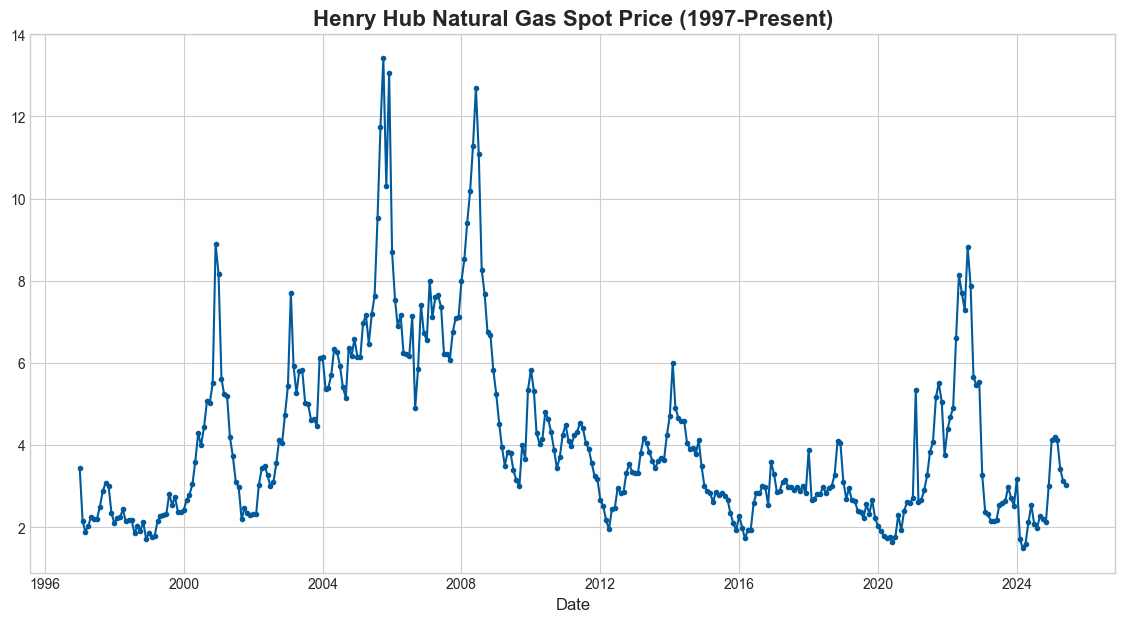

In [71]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
# Your API key.
api_key = "hM4bggzq9uz0AejSnhyETcnGEtNuVxlc6tsVbeiH" 
base_url = "https://api.eia.gov/v2/"

# --- Using the direct 'seriesid' route for Henry Hub Natural Gas Spot Price ---
series_id = 'NG.RNGWHHD.M' 
data_url = base_url + f"seriesid/{series_id}"

# We can request a longer date range for a more interesting graph
params = {
    'api_key': api_key,
    'start': '2018',
    'end': '2023'
}

print(f"--> Requesting monthly data for Series ID: {series_id}")
print(f"--> From URL: {data_url}")

# --- Make the API Request ---
try:
    response = requests.get(data_url, params=params)
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()

    # --- Load data into pandas ---
    data_records = data['response']['data']
    
    if not data_records:
        raise ValueError("API returned an empty data list for this specific query.")

    df = pd.DataFrame(data_records)

    # --- Clean and Organize the Data ---
    # Convert 'period' to datetime objects for plotting and sorting
    df['period'] = pd.to_datetime(df['period'])
    # Convert 'value' column to a numeric type for calculations and plotting
    df['value'] = pd.to_numeric(df['value'])
    # Sort the data by date chronologically
    df.sort_values('period', inplace=True)

    # --- 1. Display the Pandas Table ---
    print("\n--- Henry Hub Natural Gas Prices (Pandas DataFrame) ---")
    # In a Jupyter Notebook, display() creates a nice table.
    # In a regular script, you can use print(df)
    display(df)

    # --- 2. Export to CSV File ---
    output_filename = 'natural_gas_henry_hub_prices.csv'
    # We save the cleaned data. index=False prevents pandas from writing row numbers.
    df.to_csv(output_filename, index=False)
    print(f"\n--- SUCCESS! Data has been exported to '{output_filename}' ---")

    # --- 3. Create and Display a Graph ---
    print("\n--- Generating Price History Graph... ---")
    
    # Set a professional style for the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 7)) # Create a figure and an axes object

    # Plot the data
    ax.plot(df['period'], df['value'], marker='.', linestyle='-', color='#005a9c')

    # Set titles and labels for clarity
    ax.set_title('Henry Hub Natural Gas Spot Price (1997-Present)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(f"Price ({df['price-units'].iloc[0]})", fontsize=12)
    
    # Improve date formatting on the x-axis
    fig.autofmt_xdate()
    
    # Display the plot
    plt.show()


except requests.exceptions.RequestException as e:
    print(f"\n--> A network error occurred: {e}")
except (KeyError, ValueError) as e:
    print(f"\n--> An error occurred processing the response: {e}")
    print("Full API response:", data)
except Exception as e:
    print(f"\n--> An unexpected error occurred: {e}")
